In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 데이터 준비

In [2]:
# -------------------------------------------------
# data 불러오기
# -------------------------------------------------
df = pd.read_csv('data/bike_sharing_demand.csv', parse_dates=['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 전처리

### 파생컬럼 추가

In [3]:
# --------------------------------------------
# 연, 월, 시, 요일
# --------------------------------------------
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek # 월요일:0, 일요일:6
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


### 변수 선택

In [4]:
# --------------------------------------------
# 독립변수, 종속변수선택
# --------------------------------------------

# 독립변수에 사용하지 않을 컬럼
del_cols = ['datetime','casual','registered','count','temp'] 

X = df.drop(del_cols, axis=1).copy()
y = df['count']

X.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,0,1,14.395,81,0.0,2011,1,0,5
1,1,0,0,1,13.635,80,0.0,2011,1,1,5
2,1,0,0,1,13.635,80,0.0,2011,1,2,5
3,1,0,0,1,14.395,75,0.0,2011,1,3,5
4,1,0,0,1,14.395,75,0.0,2011,1,4,5


In [5]:
# ------------------------------------------------
# 독립변수 - 범주형, 수치형, 순환형 변수 구분
# ------------------------------------------------
cat_cols = ['season','holiday','workingday','weather']      
num_cols = ['atemp','humidity','windspeed', 'year']
cycle_cols = ['month', 'hour', 'dayofweek']

#### 순환형 데이터 인코딩

In [6]:
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

X['dayofweek_sin'] = np.sin(2 * np.pi * X['dayofweek'] / 7)
X['dayofweek_cos'] = np.cos(2 * np.pi * X['dayofweek'] / 7)


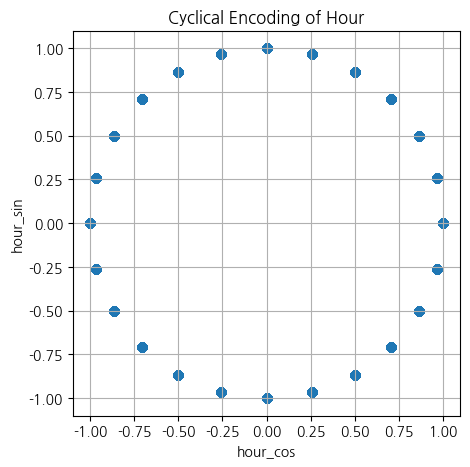

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(X['hour_cos'], X['hour_sin'])
plt.title('Cyclical Encoding of Hour')
plt.xlabel('hour_cos')
plt.ylabel('hour_sin')
plt.grid(True)
plt.show()

### 훈련세트 테스트세트 분할

In [8]:
# -------------------------
# 훈련세트/테스트세트 분할
# -------------------------

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8164, 17) (2722, 17) (8164,) (2722,)


### 수치형 변수 스케일링

In [ ]:
# -------------------------
#   스케일링
# -------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train[num_cols])
test_scaled = scaler.transform(X_test[num_cols])

# print(train_scaled)
# print(test_scaled)

# -------------------------
#   데이터프레임으로 변환
# -------------------------

X_train_scaled = train_scaled
X_test_scaled = test_scaled

X_train_scaled = pd.DataFrame(train_scaled, columns=X_train[num_cols].columns, index=X_train.index)
X_test_scaled = pd.DataFrame(test_scaled, columns=X_test[num_cols].columns, index=X_test.index)


### 범주형 변수 원핫인코딩

In [23]:
# -------------------------
#   원핫인코딩
# -------------------------

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

train_encoded = encoder.fit_transform(X_train[cat_cols])
test_encoded = encoder.transform(X_test[cat_cols])

# -------------------------
#   생성된 열 이름
# -------------------------

encode_col_names = encoder.get_feature_names_out()

# -------------------------
#   DataFrame으로 변환
# -------------------------

X_train_encoded = pd.DataFrame(train_encoded, columns=encode_col_names, index=X_train.index)
X_test_encoded = pd.DataFrame(test_encoded, columns=encode_col_names, index=X_test.index)


### 훈련에 사용할 최종 데이터 만들기

In [26]:
# 순환형 데이터 변환했으므로 컬럼명들도 바꿔주기
cycle_cols = ['hour_sin','hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']

X_train_preprocessed = pd.concat([X_train[cycle_cols], X_train_scaled, X_train_encoded], axis = 1)
X_test_preprocessed = pd.concat([X_test[cycle_cols], X_test_scaled, X_test_encoded], axis = 1)

In [31]:
X_test_preprocessed

,hour_sin,hour_cos,month_sin,month_cos,dayofweek_sin,dayofweek_cos,atemp,humidity,windspeed,year,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4
8786,2.588190e-01,-0.965926,-8.660254e-01,-5.000000e-01,0.974928,-0.222521,1.599100,-0.527973,-1.567025,1.002453,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7864,2.588190e-01,0.965926,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.344257,-0.318848,-0.211243,1.002453,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1667,7.071068e-01,-0.707107,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.075066,-0.371130,0.034813,-0.997553,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5752,-8.660254e-01,0.500000,5.000000e-01,8.660254e-01,-0.974928,-0.222521,-1.627639,-0.946222,0.527749,1.002453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5587,-5.000000e-01,0.866025,5.000000e-01,8.660254e-01,-0.974928,-0.222521,-0.193533,-1.259909,0.527749,1.002453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,-2.588190e-01,-0.965926,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,1.419837,-0.527973,0.527749,-0.997553,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7323,1.224647e-16,-1.000000,5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.702784,0.831337,1.390594,1.002453,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10193,7.071068e-01,0.707107,-5.000000e-01,8.660254e-01,-0.974928,-0.222521,-0.821250,0.988180,-1.567025,1.002453,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10052,9.659258e-01,0.258819,-5.000000e-01,8.660254e-01,-0.781831,0.623490,-1.179777,0.151682,-0.704179,1.002453,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# LinearRegression

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2 상관계수 : {r2:.3f}')
print(f'rmse : {rmse:.3f}')
print(f'mae : {mae:.3f}')
print(f'mse : {mse:.3f}')

print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2 상관계수 : 0.508
rmse : 128.027
mae : 94.185
mse : 16390.862
train>>>>>>>>>>>> 0.5123230826392543
test>>>>>>>>>>>>> 0.5076089148348149


In [14]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn.______ import _______
model = _______()
model.fit(_______, y_train)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')

# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

ModuleNotFoundError: No module named 'sklearn.______'

# DecisionTreeRegressor

In [29]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2 상관계수 : {r2:.3f}')
print(f'rmse : {rmse:.3f}')
print(f'mae : {mae:.3f}')
print(f'mse : {mse:.3f}')

print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2 상관계수 : 0.901
rmse : 57.479
mae : 34.990
mse : 3303.786
train>>>>>>>>>>>> 0.9999999962477825
test>>>>>>>>>>>>> 0.9007523480511137


In [ ]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn._______ import _______
model = _______(random_state=42)
model.fit(_______, _______)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model._______(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

r2:0.8996341877199002
rmse:57.38821994443536
mae:34.6208670095518
mse:3293.407788390889
train>>>>>>>>>>>> 0.9999967687295567
test>>>>>>>>>>>>> 0.8996341877199002


# RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2 상관계수 : {r2:.3f}')
print(f'rmse : {rmse:.3f}')
print(f'mae : {mae:.3f}')
print(f'mse : {mse:.3f}')

print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2 상관계수 : 0.946
rmse : 42.512
mae : 26.403
mse : 1807.280
train>>>>>>>>>>>> 0.9922164641663138
test>>>>>>>>>>>>> 0.9457082548392501


In [ ]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn._______ import _______
model = _______(random_state=42)
model.fit(_______, _______)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

r2:0.9528438894134199
rmse:39.336783085841866
mae:24.57365295126133
mse:1547.3825035425748
train>>>>>>>>>>>> 0.9922324356774103
test>>>>>>>>>>>>> 0.9528438894134199
